# Project Milestone 

*Work-in-progress*

<span style="color:red">Due 3/28</span>

## Basic Info

**Project Title**

<span style="color:red">TBD</span>

**Team Members**

- Soren Callo: u1407031@utah.edu, u1407031
- Carter Hardy: u1538956@utah.edu, u1538956
- Paul Nguyen: u1557320@utah.edu, u1557320

**Course Page**

- https://datasciencecourse.net/2025/project/

## Background and Motivation  

> Discuss your motivations and reasons for choosing this project, especially any background or research interests that may have influenced your decision.


Being highly motivated by learning different languages as a team, a project revolving around language was something impactful and interesting to each one of us. With a background of knowing a total of 4 languages between the 3 of us, the research interest of working with different languages and language detection influenced our final decision. Although we had lots of various ideas as we were brainstorming our ideas, language was the biggest interest that we could find motivation to research.

## Project Objectives

> Provide the primary questions you are trying to answer in your project. What would you like to learn and accomplish? List the benefits.
> - This should include both questions about the data and any learning objectives you would like to fulfill. In other words, there are two kinds of benefits to address.


Our first objective is to cluster common languages based on their linguistic properties, such as grammar, phonology, word structure, sentence structure, and so on. In doing so, the main question we would like to answer is: can we quantify the linguistic similarity of languages in a meaningful way that matches (or maybe even defies) the informal, conventional wisdom of which languages are like one another? And by selectively filtering which features we cluster by, we can learn which linguistic properties are more or less discriminating, and even some interesting particulars (for instance, two languages could be similar in sentence structure but differ drastically in phonetics).

A secondary objective we may attempt is to implement a language classifier that can identify languages from a short audio sample. This is the realm of [Spoken Language Identification](https://www.sciencedirect.com/science/article/pii/S0167639324001389), and could be a small part of a fuller speech recognition system. Such a system would be beneficial in speech-to-text and automatic translation applications. What we would like to learn from this is whether accuracy language identification can be accomplished based solely on the properties of audio signal, without having to analyze the semantics of what is being spoken.

### Imports, Constants, Setup and Initialization

In [45]:
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

import urllib.request
import re

from pathlib import Path
from bs4 import BeautifulSoup

## Data Description and Acquisition

> What format is your data in? How many items are there? What attributes do those items have? Are there special structures in it (e.g., networks, geographical)? From where and how are you collecting your data? If appropriate, provide a link to your data sources.
> - This part should be specific enough that the instructional staff is assured you have or will be able to obtain data.
> - If itâ€™s online through direct download, link to the specific page from which you will download it.
> - If you will scrape it from the web, link to the page from which you will scrape it and a statement regarding how you have confirmed you are permitted to scrape it.
If you will use an API to access it, link to the documentation of the API and explain how you have access to that API
>     - If it requires an account, state you have one.
>     - If it doesnâ€™t require an account, state that it does not require one.
> - If it is data you have access to through other means, describe in detail what the data is, how you have access to it, and why you have permission to use it.


Our basic data will come from from the [World Atlas of Linguistic Structures](https://wals.info/) (WALS) and/or [Grambank](https://grambank.clld.org/). This public data can be downloaded in various forms, scraped from the website, or found through GitHub repositories. From WALS or Grambank, we will construct a table of features by language, language families, and linguistic area of the features (e.g phonology, lexicon, etc.) Each language is associated with a [Glottolog](https://glottolog.org/)\-associated Glottocode and an ISO 639-3 code which would allow us to combine datasets, especially if we explore other sources, such as [Wikitounges](https://wikitongues.org/), [Ethnologue](https://www.ethnologue.com/) (accessed through the University of Utah), or [PHOIBLE](https://phoible.org/).

WALS data can be downloaded as tab-separated values, HTML, or JSON. For Grambank and Glottolog, we will likely need to work through the GitHub repository. WALS tab-separated values tables include language name, genus, and family, feature value, coordinates, and area. The features we will be exploring are typically categorical. For example, *tone* can take values *no tones, simple tonal system*, or *complex tonal system*.

**Citation**

> Dryer, Matthew S. & Haspelmath, Martin (eds.) 2013.  
> WALS Online (v2020.4) [Data set]. Zenodo.  
> https://doi.org/10.5281/zenodo.13950591  
> (Available online at https://wals.info)  

For audio data, we can use Mozilla's open-source [Common Voice dataset](https://commonvoice.mozilla.org/en/datasets), a vast collection of speech recordings in MP3 format. Freely available, they only require an email sign-up for contact purposes.

#### WALS dataset

We downloaded a local copy of the dataset from their [github repository](https://github.com/cldf-datasets/wals). The entire repo contains the chapters, narrations, and other related files that accompany the data for the online database, so we save the raw data into a single csv file [`WALS.csv`](data/raw/WALS.csv). 

In [49]:
raw_df = pd.read_csv('data/raw/WALS.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2679 entries, 0 to 2678
Columns: 202 entries, wals_code to 79B Suppletion in Imperatives and Hortatives
dtypes: float64(2), object(200)
memory usage: 4.1+ MB


In [50]:
raw_df.fillna('')

wals_code iso_code glottocode                  Name   latitude  \
0          aab                             Arapesh (Abu)  -3.450000   
1          aar      aiw   aari1239                  Aari   6.000000   
2          aba      aau   abau1245                  Abau  -4.000000   
3          abb      shu   chad1249      Arabic (Chadian)  13.833333   
4          abd      abi   abid1235                Abidji   5.666667   
...        ...      ...        ...                   ...        ...   
2674       zte      zpz   texm1235  Zapotec (Texmelucan)  16.500000   
2675       zul      zul   zulu1248                  Zulu -30.000000   
2676       zun      zun   zuni1245                  Zuni  35.083333   
2677       zya      zav   yatz1235    Zapotec (Yatzachi)  17.200000   
2678       zzo      zpq   zoog1238    Zapotec (Zoogocho)  17.250000   

       longitude           genus        family      macroarea countrycodes  \
0     142.950000  Kombio-Arapesh    Torricelli                          PG   
1      36.583333    South Omotic  Afro-Asiatic         Africa           ET   
2     141.250000     Upper Sepik         Sepik      Papunesia           PG   
3      20.833333         Semitic  Afro-Asiatic         Africa           TD   
4      -4.583333             Kwa   Niger-Congo         Africa           CI   
...          ...             ...           ...            ...          ...   
2674  -97.166667       Zapotecan  Oto-Manguean  North America           MX   
2675   30.000000         Bantoid   Niger-Congo         Africa           ZA   
2676 -108.833333            Zuni          Zuni  North America           US   
2677  -96.200000       Zapotecan  Oto-Manguean  North America           MX   
2678  -96.250000       Zapotecan  Oto-Manguean  North America           MX   

      ...  137B M in Second Person Singular  136B M in First Person Singular  \
0     ...                                                                      
1     ...                                                                      
2     ...                                                                      
3     ...                                                                      
4     ...                                                                      
...   ...                               ...                              ...   
2674  ...                                                                      
2675  ...  1 No m in second person singular     2 m in first person singular   
2676  ...  1 No m in second person singular  1 No m in first person singular   
2677  ...                                                                      
2678  ...                                                                      

     109B Other Roles of Applied Objects 10B Nasal Vowels in West Africa  \
0                                                                          
1                                                                          
2                                                                          
3                                                                          
4                                                                          
...                                  ...                             ...   
2674                                                                       
2675                        1 Instrument                                   
2676                                                                       
2677                                                                       
2678                                                                       

     25B Zero Marking of A and P Arguments  \
0                                            
1                                            
2                                            
3                                            
4                                            
...                                    ...   
2674               

#### The 200-Language Sample

From [Â§3.1](https://wals.info/chapter/s1#3.1._The_WALS_samples) of the WALS [Chapter Introduction](https://wals.info/chapter/s1): 

> There is a total of 2662 languages which appear on at least one map in the atlas. Some of these languages (262 in number) appear on only one map, while some, such as English, appear on most of the maps. There are 180 languages which appear on at least 80 maps, and 449 languages which appear on at least 40 maps. The choice of which languages to include on particular maps was the choice of individual authors. However, there is a set of 100 languages (hereafter the 100-language sample) which authors were asked to include on their maps if at all possible, and a further 100 languages which authors were encouraged to include on their maps (hereafter these two sets of 100 languages together are referred to as the 200-language sample).

While the full dataset is great for geographical visualizations (more datapoints = prettier maps), 
it may be helpful to analyze a smaller sample set of languages, especially when it comes to running potentially time-consuming clustering or machine learning algorithms. As described above, the WALS authors have curated a list of 200 "featured" languages that are presumably more prominent or more salient for the purposes of linguistic analysis. 

While we could not find a direct download of this 200-language sample, we can scrape the online page for the [200-language sample](https://wals.info/languoid/samples/200) for the lanuage codes, and then use this to subset the full dataset in order to create a copy of the 200-language sample ourselves. 

In [52]:
#########################################################################################
# This is to prevent re-running the code after the sample has been acquired already. 
# Set to `True` in order to force it to run again. 
RUN_IT_AGAIN = False 
#########################################################################################

URL = 'https://wals.info/languoid/samples/200'
SNAPSHOT_PATH = Path('data') / 'raw' / '200-language-sample_snapshot.html' 
SAMPLE_200_PATH = Path('data') / 'raw' / '200-language-sample.csv'

def _download_200_lang_sample(url, local_path, *, confirm = True): 
	"""Downloads the 200 language sample webpage of the WALS online database 
	from the given url and saves it to the given local path."""

	if confirm and local_path.exists(): 
		print(f'`{local_path}` already exists.')
		response = input('Do you want to download again and overwrite? (y/n)')

		if response.lower() != 'y': 
			print('...nothing to be done.')
			return

	print('Downloading...')

	with urllib.request.urlopen(url) as response:
		html = response.read()
		html = html.decode('utf-8')

	local_path.write_text(html)
	print('...done.')

def _extract_200_langs(path):
	"""From the 200-language sample HTML snapshot located at the given Path, 
	extract and yield each pair of (language code, language name) in the table."""

	soup = BeautifulSoup(path.read_text())
	table = soup.find('table')

	# Get the column index for `Code` and `Name`. 
	# By visual inspection of the webpage, we can see that it should be `1` and `2`, 
	# but extracting this programmatically from the header is slightly more robust. 
	header = table.find('thead')
	columns = re.findall(r'<th>(.*?)</th>', str(header))
	code_index = columns.index('Code')
	name_index = columns.index('Name')

	rows = table.find('tbody').find_all('tr')

	for row in rows: 
		tdata = row.find_all('td')
		lang_code = tdata[code_index].string
		lang_name = tdata[name_index].string
		yield lang_code, lang_name

def filter_200_lang_sample(df, *, confirm = True): 
	"""Given a dataframe contain the WALS dataset (raw or cleaned), 
	return a subset consisting of only the 200-language sample."""
	langs200 = list(_extract_200_langs(SNAPSHOT_PATH))
	codes200 = {code for code, name in langs200}
	mask = df['wals_code'].isin(codes200)
	sample200 = df[mask].reset_index(drop = True)

	print('Saving data...')

	if confirm and (path := SAMPLE_200_PATH).exists(): 
		reply = input(f'`{path}` exists. Overwrite? (y/n) ')

		if reply.lower() != 'y': 
			return sample200
	
	sample200.to_csv(path, index = False)
	print('...done.')
	return sample200

if RUN_IT_AGAIN: 
	_download_200_lang_sample(URL, SNAPSHOT_PATH)
	sample200 = filter_200_lang_sample(raw_df)

In [53]:
# Load from saved file
sample200 = pd.read_csv('data/raw/200-language-sample.csv')
sample200.info()
sample200[['wals_code', 'Name', 'macroarea', 'countrycodes']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 202 entries, wals_code to 79B Suppletion in Imperatives and Hortatives
dtypes: float64(5), object(197)
memory usage: 315.8+ KB


wals_code               Name      macroarea countrycodes
0         abi             AbipÃ³n  South America           AR
1         abk             Abkhaz        Eurasia           GE
2         aco              Acoma  North America           US
3         aeg  Arabic (Egyptian)         Africa           EG
4         ain               Ainu        Eurasia           JP
..        ...                ...            ...          ...
195       ypk   Yup'ik (Central)  North America           US
196       yuc              Yuchi  North America           US
197       yur              Yurok  North America           US
198       zqc  Zoque (CopainalÃ¡)  North America           MX
199       zul               Zulu         Africa           ZA

[200 rows x 4 columns]

## Ethical Considerations

> Complete a stakeholder analysis for your project.
> - Who may be affected by your project and its outcomes? How could you project be used for harm?
>     - "There are no ethical considerations" must be strongly defended. No one has successfully done this before in this class.

This project and its outcomes can affect the different populations and people who speak the different languages we might analyze. Other people can take the results we might find and assign racist or prejudiced ideas that they create by their own bias. Some people who speak languages we analyze might be affected by their own prejudice or bias and find other languages offending. We strongly do not want to add any prejudiced ideas about language and different ethnicities in our project. We want to explore the data of different languages because we find diverse cultures and languages to be an important part of humanity and hope that this project inspires others to find language and diverse culture important and interesting, inspiring them to begin their own studies and connection.

The collection of this data was not done by us, but we hope and assume that there was informed consent practiced with the different participants in this dataset and that they have consented to their data being published and allowed to be used by us. If we were to learn that a group of participants choose not to have their data be included in our project we would exclude that group and respect their wish in how their data be used. We hope that the groups who gave their data in this data collection are positively rewarded by their data being used by the results of studies both by us and anyone else who uses this data.

In addition, spoken language identification could be the first step to a speaker identification system, which could be abused to violate individual privacy or even target people for advertising and other unsavory purposes.

## Data Cleaning and Processing

> Do you expect to do substantial data cleanup or data extraction? What quantities do you plan to derive from your data? How will data processing be implemented?

The datasets from the online resources previously mentioned contain enormous amounts of data, which will make the training algorithms take a lot of time and processing power. We will certainly need to filter them heavily by choosing a small set of features to focus on, or only taking a small sample of full datasets offered by these resources.

In addition, since most of the linguistic features are categorical, we need to one-hot encoding them. 

For audio samples, we may need to convert them into a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) in order to process them.

#### One-hot encoding the dataset

In [59]:
CLEAN_IT_AGAIN = False

def one_hot_encode(in_filename, out_filename): 
	data = pd.read_csv(in_filename)

	#creating one-hot encoding representations of features and families
	feature_dummies = pd.get_dummies(data[data.columns.to_list()[10:]],dtype='int',dummy_na=True)
	family_dummies = pd.get_dummies(data['family'],dtype='int')
	names = data[data.columns.to_list()[:10]]
	cleaned_data = pd.concat([names,family_dummies,feature_dummies], axis = 1)
	print(cleaned_data.shape)

	cleaned_data.to_csv(out_filename, index=False)

	return cleaned_data

if CLEAN_IT_AGAIN: 
	data = one_hot_encode('data/raw/WALS.csv', 'data/cleaned/language_data.csv')
	display(data.dropna())
	sample200 = one_hot_encode('data/raw/200-language-sample.csv', 'data/cleaned/200-language-sample.csv')
	display(sample200)

## Exploratory Analysis

> Which methods and visualizations are you planning to use to look at your dataset?


Histograms, scatter plots, and heat maps will likely be our main visualization methods. Since there are lots of different language features, for clustering, we will need to investigate methods for visualizing high-dimensional data or apply dimensionality reduction. This is something we hope to learn in a future lecture :)

In [62]:
# Load from saved data
data = pd.read_csv('data/cleaned/language_data.csv')
sample200 = pd.read_csv('data/cleaned/200-language-sample.csv')

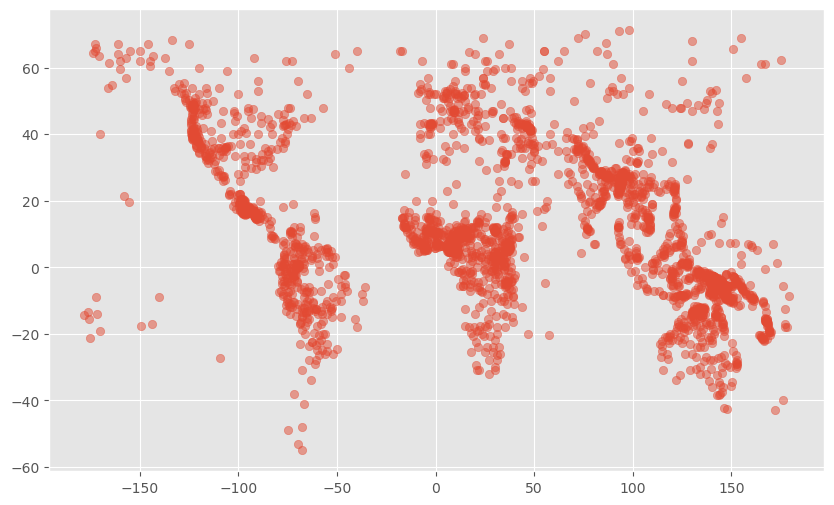

In [63]:
#A map of dataâ€”looks about right
plt.scatter(data['longitude'],data['latitude'], alpha = 0.5)
plt.show()

**Preliminary Decision Tree Analysis**

In [79]:
#Imports
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree

In [85]:
#What are the largest families in the dataset?
families = data.groupby(by="family")
print(families.size().sort_values())

#For now, I'm just going to focus on the largest language families and their phonologies. 

largest_families = ['Sino-Tibetan',
                  'Trans-New Guinea',
                  'Indo-European',
                  'Niger-Congo',
                  'Austronesian',
                  'Afro-Asiatic'] 

sample200_1 = sample200.loc[data['family'].isin(largest_families)]

phonological_features = ['1A Consonant Inventories_1 Small',
 '1A Consonant Inventories_2 Moderately small',
 '1A Consonant Inventories_3 Average',
 '1A Consonant Inventories_4 Moderately large',
 '1A Consonant Inventories_5 Large',
 '1A Consonant Inventories_nan',
 '2A Vowel Quality Inventories_1 Small (2-4)',
 '2A Vowel Quality Inventories_2 Average (5-6)',
 '2A Vowel Quality Inventories_3 Large (7-14)',
 '2A Vowel Quality Inventories_nan',
 '3A Consonant-Vowel Ratio_1 Low',
 '3A Consonant-Vowel Ratio_2 Moderately low',
 '3A Consonant-Vowel Ratio_3 Average',
 '3A Consonant-Vowel Ratio_4 Moderately high',
 '3A Consonant-Vowel Ratio_5 High',
 '3A Consonant-Vowel Ratio_nan',
 '4A Voicing in Plosives and Fricatives_1 No voicing contrast',
 '4A Voicing in Plosives and Fricatives_2 In plosives alone',
 '4A Voicing in Plosives and Fricatives_3 In fricatives alone',
 '4A Voicing in Plosives and Fricatives_4 In both plosives and fricatives',
 '4A Voicing in Plosives and Fricatives_nan',
 '5A Voicing and Gaps in Plosive Systems_1 Other',
 '5A Voicing and Gaps in Plosive Systems_2 None missing in /p t k b d g/',
 '5A Voicing and Gaps in Plosive Systems_3 Missing /p/',
 '5A Voicing and Gaps in Plosive Systems_4 Missing /g/',
 '5A Voicing and Gaps in Plosive Systems_5 Both missing',
 '5A Voicing and Gaps in Plosive Systems_nan',
 '6A Uvular Consonants_1 None',
 '6A Uvular Consonants_2 Uvular stops only',
 '6A Uvular Consonants_3 Uvular continuants only',
 '6A Uvular Consonants_4 Uvular stops and continuants',
 '6A Uvular Consonants_nan',
 '7A Glottalized Consonants_1 No glottalized consonants',
 '7A Glottalized Consonants_2 Ejectives only',
 '7A Glottalized Consonants_3 Implosives only',
 '7A Glottalized Consonants_4 Glottalized resonants only',
 '7A Glottalized Consonants_5 Ejectives and implosives',
 '7A Glottalized Consonants_6 Ejectives and glottalized resonants',
 '7A Glottalized Consonants_7 Implosives and glottalized resonants',
 '7A Glottalized Consonants_nan',
 '8A Lateral Consonants_1 No laterals',
 '8A Lateral Consonants_2 /l/, no obstruent laterals',
 '8A Lateral Consonants_3 Laterals, but no /l/, no obstruent laterals',
 '8A Lateral Consonants_4 /l/ and lateral obstruent',
 '8A Lateral Consonants_5 No /l/, but lateral obstruents',
 '8A Lateral Consonants_nan',
 '9A The Velar Nasal_1 Initial velar nasal',
 '9A The Velar Nasal_2 No initial velar nasal',
 '9A The Velar Nasal_3 No velar nasal',
 '9A The Velar Nasal_nan',
 '10A Vowel Nasalization_1 Contrast present',
 '10A Vowel Nasalization_2 Contrast absent',
 '10A Vowel Nasalization_nan',
 '11A Front Rounded Vowels_1 None',
 '11A Front Rounded Vowels_2 High and mid',
 '11A Front Rounded Vowels_3 High only',
 '11A Front Rounded Vowels_4 Mid only',
 '11A Front Rounded Vowels_nan',
 '12A Syllable Structure_1 Simple',
 '12A Syllable Structure_2 Moderately complex',
 '12A Syllable Structure_3 Complex',
 '12A Syllable Structure_nan',
 '13A Tone_1 No tones',
 '13A Tone_2 Simple tone system',
 '13A Tone_3 Complex tone system',
 '13A Tone_nan',
 '14A Fixed Stress Locations_1 No fixed stress',
 '14A Fixed Stress Locations_2 Initial',
 '14A Fixed Stress Locations_3 Second',
 '14A Fixed Stress Locations_5 Antepenultimate',
 '14A Fixed Stress Locations_6 Penultimate',
 '14A Fixed Stress Locations_7 Ultimate',
 '14A Fixed Stress Locations_nan',
 '15A Weight-Sensitive Stress_1 Left-edge: First or second',
 '15A Weight-Sensitive Stress_3 Right-edge: Ultimate or penultimate',
 '15A Weight-Sensitive Stress_4 Right-oriented: One of the last three',
 '15A Weight-Sensitive Stress_5 Unbounded: Stress can be anywhere',
 '15A Weight-Sensitive Stress_6 Combined: Right-edge and unbounded',
 '15A Weight-Sensitive Stress_7 Not predictable',
 '15A Weight-Sensitive Stress_8 Fixed stress (no weight-sensitivity)',
 '15A Weight-Sensitive Stress_nan',
 '16A Weight Factors in Weight-Sensitive Stress Systems_1 No weight',
 '16A Weight Factors in Weight-Sensitive Stress Systems_2 Long vowel',
 '16A Weight Factors in Weight-Sensitive Stress Systems_3 Coda consonant',
 '16A Weight Factors in Weight-Sensitive Stress Systems_4 Long vowel or coda consonant',
 '16A Weight Factors in Weight-Sensitive Stress Systems_5 Prominence',
 '16A Weight Factors in Weight-Sensitive Stress Systems_6 Lexical stress',
 '16A Weight Factors in Weight-Sensitive Stress Systems_7 Combined',
 '16A Weight Factors in Weight-Sensitive Stress Systems_nan',
 '17A Rhythm Types_1 Trochaic',
 '17A Rhythm Types_2 Iambic',
 '17A Rhythm Types_3 Dual: both trochaic and iambic',
 '17A Rhythm Types_4 Undetermined',
 '17A Rhythm Types_5 No rhythmic stress',
 '17A Rhythm Types_nan',
 '18A Absence of Common Consonants_1 All present',
 '18A Absence of Common Consonants_2 No bilabials',
 '18A Absence of Common Consonants_3 No fricatives',
 '18A Absence of Common Consonants_4 No nasals',
 '18A Absence of Common Consonants_nan',
 '19A Presence of Uncommon Consonants_1 None',
 '19A Presence of Uncommon Consonants_2 Clicks',
 '19A Presence of Uncommon Consonants_3 Labial-velars',
 '19A Presence of Uncommon Consonants_4 Pharyngeals',
 "19A Presence of Uncommon Consonants_5 'Th' sounds",
 '19A Presence of Uncommon Consonants_7 Pharyngeals and "th"',
 '19A Presence of Uncommon Consonants_nan']

phonology = pd.concat([sample200_1[largest_families],sample200_1[phonological_features],sample200_1['Name']],axis=1)

phonology.describe()

family
Leko               1
Kutenai            1
Kwaza              1
Laal               1
Zuni               1
                ... 
Afro-Asiatic     145
Sino-Tibetan     149
Indo-European    176
Austronesian     325
Niger-Congo      327
Length: 256, dtype: int64


Sino-Tibetan  Trans-New Guinea  Indo-European  Niger-Congo  \
count     97.000000         97.000000      97.000000    97.000000   
mean       0.030928          0.092784       0.030928     0.051546   
std        0.174022          0.291636       0.174022     0.222258   
min        0.000000          0.000000       0.000000     0.000000   
25%        0.000000          0.000000       0.000000     0.000000   
50%        0.000000          0.000000       0.000000     0.000000   
75%        0.000000          0.000000       0.000000     0.000000   
max        1.000000          1.000000       1.000000     1.000000   

       Austronesian  Afro-Asiatic  1A Consonant Inventories_1 Small  \
count     97.000000     97.000000                         97.000000   
mean       0.061856      0.051546                          0.185567   
std        0.242145      0.222258                          0.390776   
min        0.000000      0.000000                          0.000000   
25%        0.000000      0.000000                          0.000000   
50%        0.000000      0.000000                          0.000000   
75%        0.000000      0.000000                          0.000000   
max        1.000000      1.000000                          1.000000   

       1A Consonant Inventories_2 Moderately small  \
count                                    97.000000   
mean                                      0.226804   
std                                       0.420940   
min                                       0.000000   
25%                                       0.000000   
50%                                       0.000000   
75%                                       0.000000   
max                                       1.000000   

       1A Consonant Inventories_3 Average  \
count                           97.000000   
mean                             0.257732   
std                              0.439658   
min                              0.000000   
25%                              0.000000   
50%                              0.000000   
75%                              1.000000   
max                              1.000000   

       1A Consonant Inventories_4 Moderately large  ...  \
count                                    97.000000  ...   
mean                                      0.185567  ...   
std                                       0.390776  ...   
min                                       0.000000  ...   
25%                                       0.000000  ...   
50%                                       0.000000  ...   
75%                                       0.000000  ...   
max                                       1.000000  ...   

       18A Absence of Common Consonants_3 No fricatives  \
count                                         97.000000   
mean                                           0.072165   
std                                            0.260105   
min                                            0.000000   
25%                                            0.000000   
50%                                            0.000000   
75%                                            0.000000   
max                                            1.000000   

       18A Absence of Common Consonants_4 No nasals  \
count                                     97.000000   
mean                                       0.010309   
std                                        0.101535   
min                                        0.000000   
25%                                        0.000000   
50%                                        0.000000   
75%                                        0.000000   
max                                        1.000000   

       18A Absence of Common Consonants_nan  \
count                             97.000000   
mean                               0.020619   
std                                0.142842   
min                                0.000000   
25%                                0.000000   
50%       

In [87]:
#These will be useful
phonology_feature_names = phonology.iloc[:, np.arange(6,113)].columns.to_list()
phonology_features = phonology.iloc[:, np.arange(6,113)]

Now for some analysis. As we increase max depth, how does the accuracy of the classifier chance? Let's start with Indo-European, Sino Tibetan, and Austronesian.

In [89]:
#Indo European

for i in np.arange(1,10):
    decisionTree = tree.DecisionTreeClassifier(max_depth=i)
    decisionTree = decisionTree.fit(phonology_features, phonology['Indo-European'])
    y_pred = decisionTree.predict(phonology_features)
    print("max depth: ",i," accuracy: ",metrics.accuracy_score(y_true = phonology['Indo-European'], y_pred = y_pred))

max depth:  1  accuracy:  0.9690721649484536
max depth:  2  accuracy:  0.979381443298969
max depth:  3  accuracy:  0.9896907216494846
max depth:  4  accuracy:  0.9896907216494846
max depth:  5  accuracy:  1.0
max depth:  6  accuracy:  1.0
max depth:  7  accuracy:  1.0
max depth:  8  accuracy:  1.0
max depth:  9  accuracy:  1.0


In [91]:
#Sino Tibetan

for i in np.arange(1,10):
    decisionTree = tree.DecisionTreeClassifier(max_depth=i)
    decisionTree = decisionTree.fit(phonology_features, phonology['Sino-Tibetan'])
    y_pred = decisionTree.predict(phonology_features)
    print("max depth: ",i," accuracy: ",metrics.accuracy_score(y_true = phonology['Sino-Tibetan'], y_pred = y_pred))

max depth:  1  accuracy:  0.9690721649484536
max depth:  2  accuracy:  0.979381443298969
max depth:  3  accuracy:  0.979381443298969
max depth:  4  accuracy:  1.0
max depth:  5  accuracy:  1.0
max depth:  6  accuracy:  1.0
max depth:  7  accuracy:  1.0
max depth:  8  accuracy:  1.0
max depth:  9  accuracy:  1.0


In [93]:
#Austronesian

for i in np.arange(1,10):
    decisionTree = tree.DecisionTreeClassifier(max_depth=i)
    decisionTree = decisionTree.fit(phonology_features, phonology['Austronesian'])
    y_pred = decisionTree.predict(phonology_features)
    print("max depth: ",i," accuracy: ",metrics.accuracy_score(y_true = phonology['Austronesian'], y_pred = y_pred))

max depth:  1  accuracy:  0.9381443298969072
max depth:  2  accuracy:  0.9381443298969072
max depth:  3  accuracy:  0.9587628865979382
max depth:  4  accuracy:  0.979381443298969
max depth:  5  accuracy:  0.9896907216494846
max depth:  6  accuracy:  0.9896907216494846
max depth:  7  accuracy:  1.0
max depth:  8  accuracy:  1.0
max depth:  9  accuracy:  1.0


Now let's make a decision tree, starting again with Indo-European using a max depth of 3

In [95]:
decisionTree = tree.DecisionTreeClassifier(max_depth=3)

decisionTree = decisionTree.fit(phonology.iloc[:, np.arange(6,113)], phonology['Indo-European'])

y_pred = decisionTree.predict(phonology.iloc[:, np.arange(6,113)])

print(metrics.accuracy_score(y_true = phonology['Indo-European'], y_pred = y_pred))

#Printing the tree
print(tree.export_text(decisionTree, feature_names = phonology_feature_names))

#Printing which languages were misclassified
for i in np.arange(len(phonology)):
    a = decisionTree.predict(phonology.iloc[:, np.arange(6,113)])[i]
    language_name = phonology['Name'].to_list()[i]
    True_value = phonology['Indo-European'].to_list()[i]
    True_data = data.loc[data['Name'] == language_name][['Name','family','countrycodes','genus','macroarea']]
    if True_value != a:
        print("misclassified:",language_name, "\n   true family: ", True_data['family'].to_string(index=False))
    #if True_value == a:
        #print("correctly classified:",language_name)

0.9896907216494846
|--- 12A Syllable Structure_3 Complex <= 0.50
|   |--- class: 0
|--- 12A Syllable Structure_3 Complex >  0.50
|   |--- 15A Weight-Sensitive Stress_5 Unbounded: Stress can be anywhere <= 0.50
|   |   |--- 16A Weight Factors in Weight-Sensitive Stress Systems_4 Long vowel or coda consonant <= 0.50
|   |   |   |--- class: 0
|   |   |--- 16A Weight Factors in Weight-Sensitive Stress Systems_4 Long vowel or coda consonant >  0.50
|   |   |   |--- class: 1
|   |--- 15A Weight-Sensitive Stress_5 Unbounded: Stress can be anywhere >  0.50
|   |   |--- class: 1

misclassified: Persian 
   true family:  Indo-European


According to this model, if a language has only continuant uvual consonants, it is Indo-European.
If not, but it has a complex syllable structure and no initial velar nasal, it is also Indo-European. 
Otherwise, it's not Indo-European.

With the larger dataset, I expect uvual continuants will not be so important.

Spanish was misclassified because its syllable structure is only moderately complex. 

All three misclassified non-IE languages were Afroasiatic: Egyptian Arabic, Beja, and Berber. Beja is a language of Sudan with a complex syllable structure that lacks uvualar consonants and velar nasals. Berber is a language of ðŸ‡²ðŸ‡¦ which is similarly misclassified.

Why might this be?

How about Austronesian?

In [97]:
decisionTree = tree.DecisionTreeClassifier(max_depth=1)

decisionTree = decisionTree.fit(phonology.iloc[:, np.arange(6,113)], phonology['Austronesian'])

y_pred = decisionTree.predict(phonology.iloc[:, np.arange(6,113)])

print(metrics.accuracy_score(y_true = phonology['Austronesian'], y_pred = y_pred))

print(tree.export_text(decisionTree, feature_names = phonology_feature_names))

for i in np.arange(len(phonology)):
    a = decisionTree.predict(phonology.iloc[:, np.arange(6,113)])[i]
    language_name = phonology['Name'].to_list()[i]
    True_value = phonology['Austronesian'].to_list()[i]
    True_data = data.loc[data['Name'] == language_name][['Name','family','countrycodes','genus','macroarea']]
    if True_value != a:
        print("misclassified:",language_name, "\n   true family: ", True_data['family'].to_string(index=False))
    #if True_value == a:
        #print("correctly classified:",language_name)

0.9381443298969072
|--- 9A The Velar Nasal_1 Initial velar nasal <= 0.50
|   |--- class: 0
|--- 9A The Velar Nasal_1 Initial velar nasal >  0.50
|   |--- class: 0

misclassified: Drehu 
   true family:  Austronesian
misclassified: Kiribati 
   true family:  Austronesian
misclassified: Malagasy 
   true family:  Austronesian
misclassified: Maori 
   true family:  Austronesian
misclassified: Paamese 
   true family:  Austronesian
misclassified: Taba 
   true family:  Austronesian


In [99]:
#Trans New Guinean?

decisionTree = tree.DecisionTreeClassifier(max_depth=2)

decisionTree = decisionTree.fit(phonology.iloc[:, np.arange(6,113)], phonology['Trans-New Guinea'])

y_pred = decisionTree.predict(phonology.iloc[:, np.arange(6,113)])

print(metrics.accuracy_score(y_true = phonology['Trans-New Guinea'], y_pred = y_pred))

print(tree.export_text(decisionTree, feature_names = phonology_feature_names))

for i in np.arange(len(phonology)):
    a = decisionTree.predict(phonology.iloc[:, np.arange(6,113)])[i]
    language_name = phonology['Name'].to_list()[i]
    True_value = phonology['Trans-New Guinea'].to_list()[i]
    True_data = data.loc[data['Name'] == language_name][['Name','family','countrycodes','genus','macroarea']]
    if True_value != a:
        print("misclassified:",language_name, "\n   true family: ", True_data['family'].to_string(index=False))
    #if True_value == a:
        #print("correctly classified:",language_name)

0.9484536082474226
|--- 16A Weight Factors in Weight-Sensitive Stress Systems_6 Lexical stress <= 0.50
|   |--- 5A Voicing and Gaps in Plosive Systems_5 Both missing <= 0.50
|   |   |--- class: 0
|   |--- 5A Voicing and Gaps in Plosive Systems_5 Both missing >  0.50
|   |   |--- class: 1
|--- 16A Weight Factors in Weight-Sensitive Stress Systems_6 Lexical stress >  0.50
|   |--- 1A Consonant Inventories_1 Small <= 0.50
|   |   |--- class: 0
|   |--- 1A Consonant Inventories_1 Small >  0.50
|   |   |--- class: 1

misclassified: Amele 
   true family:  Trans-New Guinea
misclassified: Dani (Lower Grand Valley) 
   true family:  Trans-New Guinea
misclassified: Hamtai 
   true family:  Trans-New Guinea
misclassified: Kewa 
   true family:  Trans-New Guinea
misclassified: Kobon 
   true family:  Trans-New Guinea


## Analysis Methodology

> How are you planning to analyze your data?
> - What specific questions do you hope to calculate?
> - What methods (from class or otherwise) do you think you will use?


We will start with K-Means to try and cluster languages by a select set of linguistic features, and maybe even geographic/location data.
We hope to be able to calculate a similarity or distance score between languages, and maybe even see how this changes when we change the feature set. For speech data, we will see if a k-Nearest Neighbors model can build an effective language identifier, and we may explore other classification methods as needed.


## Project Schedule

> Make sure that you plan your work so that you can avoid a big rush right before the final project deadline, and delegate different modules and responsibilities among your team members. Write this in terms of weekly deadlines.

**Week 1: March 17 - 21**

- Acquire and clean/filter datasets

**Week 2: March 24 - 28**

- Explore, investigate, and understand the dataset
- First milestone **due Friday 3/28**

**Week 3: March 31 - April 4**

- Perform preliminary clustering and/or classification
- Evaluate results
- Iterate and improve performance if possible

**Week 4: April 7 - 11**

- Reflect on and write up analysis of results
- Analysis **due Friday 4/11**

**Week 5: April 14 - 18**

- Record video for submission (**due Friday 4/18**)


In [ ]:
%%html
<style>
	blockquote {
		color: gray;
	}
</style>